In [22]:
import numpy as np
from matplotlib import pyplot as plt
from bta import *
import os
import tdt

In [23]:
dir = r"C:\Users\maxma\OneDrive\Desktop\Shared Fiber Pho\FiberPhoStuff\data"
bpa = []
for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".tev"):
                  bpa.append(root)

In [36]:
from bta._types import TDTEpoc, TDTStream

def get_data(epoc: TDTEpoc, event_code: list[int], gfp: TDTStream, iso: TDTStream, TRANGE: tuple[int, int], BASELINE_PER: tuple[int, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Get Epoc average data for GFP and ISO streams

    Parameters
    ----------
    epoc : TDTEpoc
        the epoc
    event_code : list[int]
        the event code
    gfp : TDTStream
        the GFP stream
    iso : TDTStream
        the ISO stream
    TRANGE : tuple[int, int]
        the time range
    BASELINE_PER : tuple[int, int]
        the baseline period

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        the mean_iso, mean_gfp, iso_vec, gfp_vec, std_iso, std_gfp
    """
    trs = get_time_ranges(epoc, values=event_code)
    filtered_csp_trs = modify_time_ranges(epoc, TRANGE, trs)
    filtered_grbda = get_filtered_stream_data(gfp, filtered_csp_trs)
    filtered_iso = get_filtered_stream_data(iso, filtered_csp_trs)
    min1 = np.min([np.size(x) for x in filtered_grbda])
    min2 = np.min([np.size(x) for x in filtered_iso])
    # filtered_grbda = [x[1:min1] for x in filtered_grbda]
    # filtered_iso = [x[1:min2] for x in filtered_iso]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F405 = []
    F465 = []
    for lst in filtered_iso:
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F405.append(small_lst)

    for lst in filtered_grbda: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)


    #Create a mean signal, standard error of signal, and DC offset
    mean_iso = np.mean(F405, axis=0)
    std_iso = np.std(F405, axis=0)/np.sqrt(len(filtered_iso))
    dc_iso = np.mean(mean_iso)
    mean_gfp = np.mean(F465, axis=0)
    std_gfp = np.std(F465, axis=0)/np.sqrt(len(filtered_grbda))
    dc_gfp = np.mean(mean_gfp)

    # Create the time vector for each stream store
    gfp_vec = TRANGE[0] + np.linspace(1, len(mean_gfp), len(mean_gfp))/gfp.fs*N
    iso_vec = TRANGE[0] + np.linspace(1, len(mean_iso), len(mean_iso))/iso.fs*N

    # Subtract DC offset to get signals on top of one another
    mean_iso = mean_iso - dc_iso
    mean_gfp = mean_gfp - dc_gfp

    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F405, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)

    # Getting the z-score and standard error
    zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(iso_vec)<BASELINE_PER[1]) & (np.array(iso_vec)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        zall.append((dF - zb)/zsd)

        zerror = np.std(zall, axis=0)/np.sqrt(np.size(zall, axis=0))
    return zall, zerror, iso_vec, gfp_vec




In [37]:
bpa = []
dir = r'C:\Users\Daniel\Desktop\max_bta\FiberPhoStuff\data'
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith(".tev"):
            bpa.append(root)
            

In [51]:
to_analyze = {}
    
for idx, block_path in enumerate(bpa):
    # load data
    data = read_block(block_path)
    tdt_data = tdt.read_block(block_path)
    epoc_to_analyze = data.get_epoc("PrtB")
    epoc_to_analyze.onset = tdt_data.epocs.PrtB.onset
    epoc_to_analyze.offset = tdt_data.epocs.PrtB.offset
    epoc_to_analyze.data = tdt_data.epocs.PrtB.data
    gfp = data.get_stream("GFPG")
    gfp.data = tdt_data.streams.GFPG.data
    iso = data.get_stream("ISOG")
    iso.data = tdt_data.streams.ISOG.data

    if idx == 1:
        zall, zerror, iso_vec, gfp_vec = get_data(epoc_to_analyze, [38], gfp, iso, [-10, 30], [-10, 0])
    else:
        zall, zerror, iso_vec, gfp_vec = get_data(epoc_to_analyze, [34], gfp, iso, [-10, 30], [-10, 0])


    to_analyze[block_path] = {
        "zall": zall,
        "zerror": zerror,
        "iso_vec": iso_vec,
        "gfp_vec": gfp_vec
    }
    

read from t=0s to t=2113.44s
read from t=0s to t=2126.7s


In [ ]:
# example
[
    [1, 2, 3, 4],
    [5, 6, 7]
]
total = np.mean(np.array(iso_vec1, iso_vec2), axis=0)


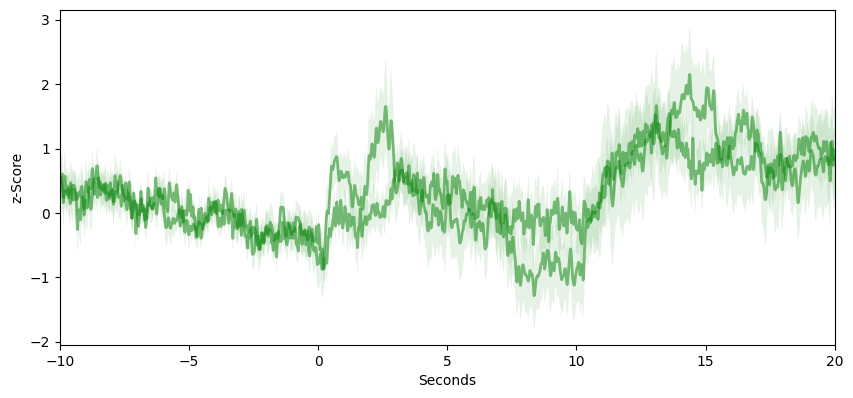

In [52]:
fig = plt.figure(figsize=(10, 20))
ax2 = fig.add_subplot(411)
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(-10, 20)
ax2.set_label('z-Score')
for block_path in to_analyze:
    ax2.plot(to_analyze[block_path]["iso_vec"], np.mean(to_analyze[block_path]["zall"], axis=0), linewidth=2, color='green', alpha=0.5)
    ax2.fill_between(to_analyze[block_path]["gfp_vec"], np.mean(to_analyze[block_path]["zall"], axis=0)+to_analyze[block_path]["zerror"]
                      ,np.mean(to_analyze[block_path]["zall"], axis=0)-to_analyze[block_path]["zerror"], facecolor='green', alpha=0.1)


In [ ]:
# Start making a figure with 4 subplots
ax0 = fig.add_subplot(5, 1, idx+1)

# Plotting the traces
p1, = ax0.plot(ts1, mean_gfp, linewidth=2, color='green', label='GrbDA')
p2, = ax0.plot(ts2, mean_iso, linewidth=2, color='blueviolet', label='ISO')

# Plotting standard error bands
p3 = ax0.fill_between(ts1, mean_gfp+std_gfp, mean_gfp-std_gfp,
                        facecolor='green', alpha=0.2)
#p4 = ax0.fill_between(ts2, mean_iso+std_iso, mean_iso-std_iso,
    #                     facecolor='blueviolet', alpha=0.2)

# Plotting a line at t = 0 and t = 10
p5 = ax0.axvline(x=0, linewidth=3, color='slategray', label='Cue Onset')
p6 = ax0.axvline(x=10, linewidth=3, color='lightblue', label='Reward Delivery')

# Finish up the plot
ax0.set_xlabel('Seconds')
ax0.set_ylabel('Signal (mV)')
ax0.set_title('GFPG vs ISOS')
ax0.legend(handles=[p1, p2, p5, p6], loc='upper right')
# to set range based on minimum and maximum values in sample. created graphs with huge ranges
# ax0.set_ylim(min(np.min(mean_gfp-std_gfp), np.min(mean_iso-std_iso)),
#             max(np.max(mean_gfp+std_gfp), np.max(mean_iso+std_iso)))
ax0.set_ylim(ymin,
                ymax)
ax0.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])